# Dog breeds prediction using deep learning methods

## Detailed desciption
The aim of the project is to find the best performing model (in terms of accuracy) for image recognition task. It is mostly focused on deep learning models and transfer learning but not only limited to it. The whole modelling process was divided into five parts to make it more clear and to easily distinguish between each of them. Additionaly during model development few general questions related to model development process arrived and answers for them were provided in coresponding parts (with numerical analysis confirming/rejecting given thesis).

Part 1. Comparison of following, pretrained (on imagenet dataset) deep neural networks on given dataset (accuracy was checked without any training):

 - Resnet50
 - InceptionV3
 - VGG16
 - Densenet
 - Xception
 - MobileNet_v2


Part 2. Transfer learning (extracting features from pretrained models and training model on it). For this task best baseline models from Part 1 were chosen.

Question 1: Does image augmentation really help?

Part 3. Training algorithms on given dataset (not using pretrained algorithms). Following algorithms were checked:

* own chosen structure of NN with trained weights
* basic random forest (without hyperparameter optimization)
* basic logistic regression (without hyperparameter optimization)

Question 2: Is gap (in accuracy) between trained neural network (on limited data and resources) and pretrained one (from Part 1) really huge?


Question 3: Is there a big difference in accuracy between neural network and other algorithms (random forest/logistic regression)?

Part 4. Model ensembling (stacking of models from previous parts):
 
Question 4: Does stacking increase accuracy?

Part 5. Detailed model predictions analysis.

Question 5: Does model predictions make sense? Is there any bias which can be observed by analysing model predictions errors/confusion matrix?

In this part predictions from best performing model will be analysed in detail.

### Source of data & description: http://vision.stanford.edu/aditya86/ImageNetDogs/ 

Original dataset has 120 classes but due to computational complexity it was reducted to 10 classes.


#### Import of required packages

In [4]:
import numpy as np 
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import datasets, layers, models
from PIL import Image
from IPython.display import Image

from keras.preprocessing import image
from keras_applications.resnet50 import ResNet50
from keras_applications.vgg16 import VGG16
from keras_applications.inception_v3 import InceptionV3
from keras_applications.densenet import DenseNet121
from keras_applications.mobilenet_v2 import MobileNetV2
from keras_applications.xception import Xception
from keras.models import load_model

from keras.applications.resnet50 import preprocess_input as preprocess_resnet50,decode_predictions
from keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from keras.applications.densenet import preprocess_input as preprocess_dense
from keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobile_v2
from keras.applications.xception import preprocess_input as preprocess_xception

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History,EarlyStopping,ModelCheckpoint,LearningRateScheduler,TensorBoard
import pickle 
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scipy.io

Using Theano backend.


In [5]:
filename ="/home/mobr93/Pulpit/bootcamp_DS/projekt/train_list.mat"
train = scipy.io.loadmat(filename)

filename2 ="/home/mobr93/Pulpit/bootcamp_DS/projekt/test_list.mat"
test = scipy.io.loadmat(filename2)

ANNOTATION_DIR = 'Annotation/'
IMAGES_DIR = 'Images/'

#### Definitions of used functions

In [6]:
# creates mapping between labels and breeds
def rasy():
    n_train=len(train['file_list'])
    rasy_train={}
    for zdj in range(n_train):
        if train['labels'][zdj][0] in range(11):
            label=train['labels'][zdj][0]-1 # labels from 0 to 9
            rasa_l=train['annotation_list'][zdj][0][0]
            rasa_l=rasa_l.split(sep='-',maxsplit=1)[1].split('/')[0]
            rasy_train[rasa_l]=label
        else:
            continue
    return rasy_train

In [7]:
# function for loading train data
def load_train(width,height,preprocess_model=None):
    n_train=len(train['file_list'])
    X_train=[]
    y_train=[]
    rasy_train={}
    for zdj in range(n_train):
        if train['labels'][zdj][0] in range(11):
            img = image.load_img(IMAGES_DIR + train['file_list'][zdj][0][0], target_size=(width, height))
            if preprocess_model:
                img = preprocess_model(image.img_to_array(img))
            else:
                img=image.img_to_array(img)
            label=train['labels'][zdj][0]-1 # labels from 0 to 9
            X_train.append(np.array(img))
            y_train.append(label)
        else:
            continue
    X_train=np.array(X_train)
    y_train=np.array(y_train)
    return X_train,y_train

In [8]:
# function for loading test data
def load_test(width,height,preprocess_model=None):
    n_test=len(test['file_list'])
    X_test=[]
    y_test=[]
    for zdj in range(n_test):
        if test['labels'][zdj][0] in range(11):
            img = image.load_img(IMAGES_DIR + test['file_list'][zdj][0][0], target_size=(width, height)) 
            if preprocess_model:
                img = preprocess_model(image.img_to_array(img))
            else:
                img=image.img_to_array(img)
            label=test['labels'][zdj][0]-1
            X_test.append(np.array(img))
            y_test.append(label)
        else:
            continue
    X_test=np.array(X_test)
    y_test=np.array(y_test)
    return X_test,y_test

In [9]:
# calculating accuracy for given model, returns accuracy and list of missclassified images
def acc(zbior_X,zbior_y,alg,decode_predictions=None):
    score=0
    missclass=[]
    for nr,img in enumerate(zbior_X):
        label=zbior_y[nr]
        preds = alg.predict(np.expand_dims(img.copy(), axis=0))
        try:
            prognoza=decode_predictions(preds, top=1)[0][0][1]
            if prognoza==list(rasy_train.keys())[label]:
                score+=1
            else:
                missclass.append(nr)
        except Exception:
            prognoza=np.argmax(preds,axis=1)
            if prognoza==label:
                score+=1
            else:
                missclass.append(nr)
    return score/len(zbior_X),missclass

In [10]:
# shows random images
def random(n):
    for i in range(n):
        rasy = os.listdir(ANNOTATION_DIR)
        rasy_fin=[]
        for a in rasy:
            for w in rasy_train.keys():
                if w in a:
                    rasy_fin.append(a)
        breed = np.random.choice(rasy_fin)
        dog = np.random.choice(os.listdir(ANNOTATION_DIR + breed))
        img = cv2.imread(IMAGES_DIR + breed + '/' + dog + '.jpg') 
        breed,dog
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.figure(figsize = (10,10))
        plt.text(5,10,breed,bbox={'facecolor': 'white'})
        plt.imshow(img);

In [11]:
# checks predictions for given image and model
def sprawdz_1(zbior_X,zbior_X_pred,zbior_y,alg,miss_class):
    for zdj in miss_class:
        img=zbior_X[zdj]
        label=zbior_y[zdj]
        preds = alg.predict_proba(zbior_X_pred[zdj].reshape(1, -1))
        predicted_class_indices = np.argmax(preds, axis = 1)
        plt.figure(figsize = (8,8))
        plt.text(5,10,f'true label={label}',bbox={'facecolor': 'white'})
        plt.text(5,25,f'prognozowany output label={predicted_class_indices}',bbox={'facecolor': 'white'})
        plt.imshow(img);

#### Loading of train/test datasets.
Pretrained models require different image preprocessing (input centering/size/scaling) therefore we load datasets separately using proper preprocessing functions from keras. This is important as weights were optimized to given format and proper preprocessing can increase accuracy.

In [12]:
X_train_res,y_train_res=load_train(224,224,preprocess_resnet50)
X_test_res,y_test_res=load_test(224,224,preprocess_resnet50)

In [10]:
X_train_inc,y_train_inc=load_train(299,299,preprocess_inception_v3)
X_test_inc,y_test_inc=load_test(299,299,preprocess_inception_v3)

In [10]:
X_train_vgg,y_train_vgg=load_train(224,224,preprocess_vgg16)
X_test_vgg,y_test_vgg=load_test(224,224,preprocess_vgg16)

In [10]:
X_train_dens,y_train_dens=load_train(224,224,preprocess_dense)
X_test_dens,y_test_dens=load_test(224,224,preprocess_dense)

In [14]:
X_train_mob,y_train_mob=load_train(224,224,preprocess_mobile_v2)
X_test_mob,y_test_mob=load_test(224,224,preprocess_mobile_v2)

In [10]:
X_train_xcep,y_train_xcep=load_train(299,299,preprocess_xception)
X_test_xcep,y_test_xcep=load_test(299,299,preprocess_xception)

In [24]:
X_train_res.shape,X_test_res.shape

((1000, 224, 224, 3), (919, 224, 224, 3))

There is 1000 images in training dataset and 919 images in original test set. This original test set was divided into two parts as described below.

#### Division of original Stanford 'test set' into two parts:
* validation set - used for early stopping cryterion during training
* test set - used for final model testing (unused during any training)

As there is relatively a lof of images in original test set (almost the same amount as in training set) division 50/50 looks most natural to assure proper number of images for validation/test sets.

In [13]:
X_val_res,X_test2_res,y_val_res,y_test2_res=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

In [11]:
X_val_inc,X_test2_inc,y_val_inc,y_test2_inc=train_test_split(X_test_inc,y_test_inc,test_size=0.5,random_state=42)

In [11]:
X_val_vgg,X_test2_vgg,y_val_vgg,y_test2_vgg=train_test_split(X_test_vgg,y_test_vgg,test_size=0.5,random_state=42)

In [11]:
X_val_dens,X_test2_dens,y_val_dens,y_test2_dens=train_test_split(X_test_dens,y_test_dens,test_size=0.5,random_state=42)

In [15]:
X_val_mob,X_test2_mob,y_val_mob,y_test2_mob=train_test_split(X_test_mob,y_test_mob,test_size=0.5,random_state=42)

In [11]:
X_val_xcep,X_test2_xcep,y_val_xcep,y_test2_xcep=train_test_split(X_test_xcep,y_test_xcep,test_size=0.5,random_state=42)

In [28]:
print(f'Training dataset has {X_train_res.shape[0]} images')
print(f'Validation dataset has {X_val_res.shape[0]} images')
print(f'Testing dataset has {X_test2_res.shape[0]} images')

Training dataset has 1000 images
Validation dataset has 459 images
Testing dataset has 460 images


#### As loading/preprocessing takes a lot of memory this datasets are saved into pickles and then they can be loaded directly from files without any prepprocessing.

In [12]:
# Xception
with open("X_train_xcep.pickle", "wb") as data:
    pickle.dump(X_train_xcep, data)
with open("y_train_xcep.pickle", "wb") as data:
    pickle.dump(y_train_xcep, data)
with open("X_val_xcep.pickle", "wb") as data:
    pickle.dump(X_val_xcep, data)
with open("X_test2_xcep.pickle", "wb") as data:
    pickle.dump(X_test2_xcep, data)
with open("y_val_xcep.pickle", "wb") as data:
    pickle.dump(y_val_xcep, data)
with open("y_test2_xcep.pickle", "wb") as data:
    pickle.dump(y_test2_xcep, data)

In [12]:
# Inception
with open("X_train_inc.pickle", "wb") as data:
    pickle.dump(X_train_inc, data)
with open("y_train_inc.pickle", "wb") as data:
    pickle.dump(y_train_inc, data)
with open("X_val_inc.pickle", "wb") as data:
    pickle.dump(X_val_inc, data)
with open("X_test2_inc.pickle", "wb") as data:
    pickle.dump(X_test2_inc, data)
with open("y_val_inc.pickle", "wb") as data:
    pickle.dump(y_val_inc, data)
with open("y_test2_inc.pickle", "wb") as data:
    pickle.dump(y_test2_inc, data)

In [12]:
# DenseNet
with open("X_train_dens.pickle", "wb") as data:
    pickle.dump(X_train_dens, data)
with open("y_train_dens.pickle", "wb") as data:
    pickle.dump(y_train_dens, data)
with open("X_val_dens.pickle", "wb") as data:
    pickle.dump(X_val_dens, data)
with open("X_test2_dens.pickle", "wb") as data:
    pickle.dump(X_test2_dens, data)
with open("y_val_dens.pickle", "wb") as data:
    pickle.dump(y_val_dens, data)
with open("y_test2_dens.pickle", "wb") as data:
    pickle.dump(y_test2_dens, data)

In [16]:
# ResNet
with open("X_train_res.pickle", "wb") as data:
    pickle.dump(X_train_res, data)
with open("y_train_res.pickle", "wb") as data:
    pickle.dump(y_train_res, data)
with open("X_val_res.pickle", "wb") as data:
    pickle.dump(X_val_res, data)
with open("X_test2_res.pickle", "wb") as data:
    pickle.dump(X_test2_res, data)
with open("y_val_res.pickle", "wb") as data:
    pickle.dump(y_val_res, data)
with open("y_test2_res.pickle", "wb") as data:
    pickle.dump(y_test2_res, data)

In [12]:
# Vgg16
with open("X_val_vgg.pickle", "wb") as data:
    pickle.dump(X_val_vgg, data)
with open("X_test2_vgg.pickle", "wb") as data:
    pickle.dump(X_test2_vgg, data)
with open("y_val_vgg.pickle", "wb") as data:
    pickle.dump(y_val_vgg, data)
with open("y_test2_vgg.pickle", "wb") as data:
    pickle.dump(y_test2_vgg, data)

In [16]:
# MobileNet
with open("X_val_mob.pickle", "wb") as data:
    pickle.dump(X_val_mob, data)
with open("X_test2_mob.pickle", "wb") as data:
    pickle.dump(X_test2_mob, data)
with open("y_val_mob.pickle", "wb") as data:
    pickle.dump(y_val_mob, data)
with open("y_test2_mob.pickle", "wb") as data:
    pickle.dump(y_test2_mob, data)

#### Loading preprocessed datasets directly from files (it is possible to load datasets preproceesed only for given achitecture (i.e. Inception_v3 network) and train only it during one kernel session.

In [10]:
# Xception
with open("X_train_xcep.pickle", "rb") as data:
    X_train_xcep = pickle.load(data)

with open("y_train_xcep.pickle", "rb") as data:
    y_train_xcep = pickle.load(data)
    
with open("X_val_xcep.pickle", "rb") as data:
    X_val_xcep = pickle.load(data)

with open("X_test2_xcep.pickle", "rb") as data:
    X_test2_xcep = pickle.load(data)

with open("y_val_xcep.pickle", "rb") as data:
    y_val_xcep = pickle.load(data)

with open("y_test2_xcep.pickle", "rb") as data:
    y_test2_xcep = pickle.load(data)

In [10]:
# Inception
with open("X_train_inc.pickle", "rb") as data:
    X_train_inc = pickle.load(data)
    
with open("y_train_inc.pickle", "rb") as data:
    y_train_inc = pickle.load(data)
    
with open("X_val_inc.pickle", "rb") as data:
    X_val_inc = pickle.load(data)

with open("X_test2_inc.pickle", "rb") as data:
    X_test2_inc = pickle.load(data)

with open("y_val_inc.pickle", "rb") as data:
    y_val_inc = pickle.load(data)

with open("y_test2_inc.pickle", "rb") as data:
    y_test2_inc = pickle.load(data)

In [22]:
# DenseNet
with open("X_train_dens.pickle", "rb") as data:
    X_train_dens = pickle.load(data)

with open("y_train_dens.pickle", "rb") as data:
    y_train_dens = pickle.load(data)
    
with open("X_val_dens.pickle", "rb") as data:
    X_val_dens = pickle.load(data)

with open("X_test2_dens.pickle", "rb") as data:
    X_test2_dens = pickle.load(data)

with open("y_val_dens.pickle", "rb") as data:
    y_val_dens = pickle.load(data)

with open("y_test2_dens.pickle", "rb") as data:
    y_test2_dens = pickle.load(data)

In [10]:
# ResNet 
with open("X_train_res.pickle", "rb") as data:
    X_train_res = pickle.load(data)

with open("y_train_res.pickle", "rb") as data:
    y_train_res = pickle.load(data)
    
with open("X_val_res.pickle", "rb") as data:
    X_val_res = pickle.load(data)

with open("X_test2_res.pickle", "rb") as data:
    X_test2_res = pickle.load(data)

with open("y_val_res.pickle", "rb") as data:
    y_val_res = pickle.load(data)

with open("y_test2_res.pickle", "rb") as data:
    y_test2_res = pickle.load(data)

In [16]:
# Vgg16
with open("X_val_vgg.pickle", "rb") as data:
    X_val_vgg = pickle.load(data)

with open("X_test2_vgg.pickle", "rb") as data:
    X_test2_vgg = pickle.load(data)

with open("y_val_vgg.pickle", "rb") as data:
    y_val_vgg = pickle.load(data)

with open("y_test2_vgg.pickle", "rb") as data:
    y_test2_vgg = pickle.load(data)

In [17]:
# MobileNet
with open("X_val_mob.pickle", "rb") as data:
    X_val_mob = pickle.load(data)

with open("X_test2_mob.pickle", "rb") as data:
    X_test2_mob = pickle.load(data)

with open("y_val_mob.pickle", "rb") as data:
    y_val_mob = pickle.load(data)

with open("y_test2_mob.pickle", "rb") as data:
    y_test2_mob = pickle.load(data)

### Part 0: Data exploration
Checking distribution of images in train/validation/test sets
* training dataset contains 100 images in each class
* validation/test sets contain around 20-80 images in each class

In [12]:
pd.Series(y_train_res).value_counts()

9    100
8    100
7    100
6    100
5    100
4    100
3    100
2    100
1    100
0    100
dtype: int64

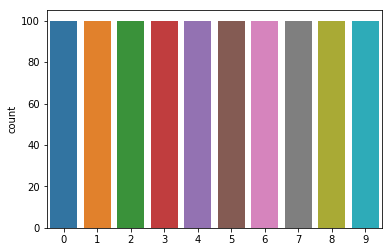

In [13]:
sns.countplot(y_train_res)

In [15]:
pd.Series(y_val_res).value_counts()

2    80
9    70
4    51
7    47
6    45
8    44
5    40
1    38
0    25
3    19
dtype: int64

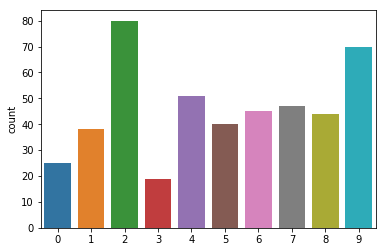

In [16]:
sns.countplot(y_val_res)

In [16]:
pd.Series(y_test2_res).value_counts()

2    72
9    69
4    63
6    51
5    48
1    47
3    30
8    28
0    27
7    25
dtype: int64

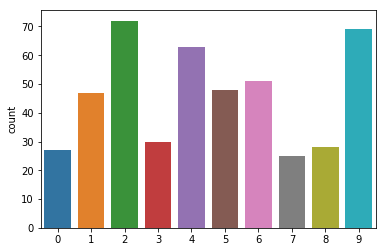

In [17]:
sns.countplot(y_test2_res)

Checking labels and names of dogs' breeds

In [14]:
rasy_train=rasy()
rasy_train

{'Chihuahua': 0,
 'Japanese_spaniel': 1,
 'Maltese_dog': 2,
 'Pekinese': 3,
 'Shih-Tzu': 4,
 'Blenheim_spaniel': 5,
 'papillon': 6,
 'toy_terrier': 7,
 'Rhodesian_ridgeback': 8,
 'Afghan_hound': 9}

Checking few random images with labels

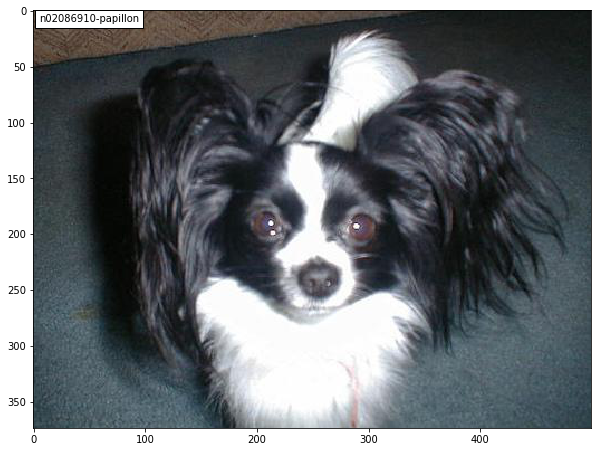

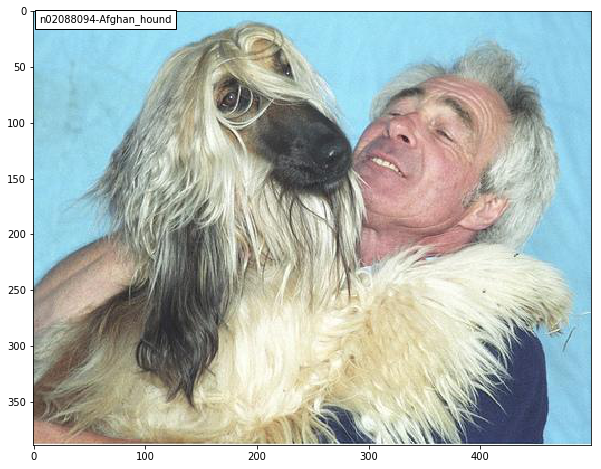

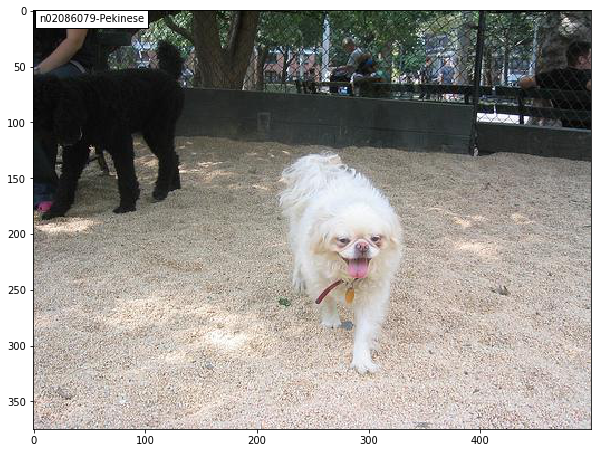

In [29]:
random(3)

### Part 1. Comparison of following, pretrained (on imagenet dataset) deep neural networks on given dataset (without any training):

* Resnet
* VGG16
* Inception_v3
* Xception
* Densenet
* MobileNet_v2

Loading of pretrained models

In [11]:
resnet_org = ResNet50(weights='imagenet', backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
resnet_org.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
vgg16_org = VGG16(
                   weights='imagenet',
                  backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)



In [19]:
vgg16_org.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
InceptionV3_org = InceptionV3(
                   weights='imagenet',
                backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
InceptionV3_org.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [20]:
dense_org = DenseNet121(
                   weights='imagenet',
                backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

In [18]:
dense_org.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

Total params: 8,062,504
Trainable params: 7,978,856
Non-trainable params: 83,648
__________________________________________________________________________________________________


In [19]:
mob_v2_org = MobileNetV2(
                   weights='imagenet',
                backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

In [13]:
mob_v2_org.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [11]:
xception_org = Xception(
                   weights='imagenet',
                backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
xception_org.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Calculating accuracy for all loaded pretrained models

In [24]:
acc(X_test2_res,y_test2_res,resnet_org,decode_predictions)[0]

0.7956521739130434

In [19]:
acc(X_test2_vgg,y_test2_vgg,vgg16_org,decode_predictions)[0]

0.7608695652173914

In [20]:
acc(X_test2_mob,y_test2_mob,mob_v2_org,decode_predictions)[0]

0.8586956521739131

In [23]:
acc(X_test2_dens,y_test2_dens,dense_org,decode_predictions)[0]

0.8456521739130435

In [12]:
acc(X_test2_xcep,y_test2_xcep,xception_org,decode_predictions)[0]

0.9108695652173913

In [16]:
acc(X_test2_inc,y_test2_inc,InceptionV3_org,decode_predictions)[0]

0.9108695652173913

#### Summary of results (accuracy):

* resnet 80%
* vgg16 76%
* **inception_v3 91%**
* densenet 85%
* mobilenet_v2 86%
* **xception 91%**

For part 2 (transfer learning) two NN structures with best score were chosen (inception/xcepion) and also one simpler with worse score (resnet) to see how much accuracy can be improved for NN with lower accuracy.

### Part 2. Transfer learning

#### Two approaches will be checked:
* training last layer of pretrained neural networks
* extracting features and training logistic regression on it 

Additionally, it will be checked whether data augmentation will give additional value (for this check resnet structure was chosen)


In [12]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
restnet = ResNet50(include_top=False, # we do not load top layer as it will be trained on given dataset
                   weights='imagenet',
                   pooling = 'avg',
                   input_shape=(IMG_HEIGHT,IMG_WIDTH,3),backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
IMG_WIDTH=299
IMG_HEIGHT=299
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
inception_v3 = InceptionV3(include_top=False, # we do not load top layer as it will be trained on given dataset
                   weights='imagenet',
                   pooling = 'avg',
                   input_shape=(IMG_HEIGHT,IMG_WIDTH,3),backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
IMG_WIDTH=299
IMG_HEIGHT=299
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
xcep = Xception(include_top=False, # we do not load top layer as it will be trained on given dataset
                   weights='imagenet',
                   pooling = 'avg', 
                   input_shape=(IMG_HEIGHT,IMG_WIDTH,3),backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

Instructions for updating:
Colocations handled automatically by placer.


#### Training last layer of Inception_v3 NN

In [12]:
output = inception_v3.layers[-1].output
for layer in inception_v3.layers:
    layer.trainable = False # freeze weights for pretrained part
inc_v3 = Sequential()
inc_v3.add(inception_v3)

inc_v3.add(Dense(10, activation='softmax'))

inc_v3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
            metrics=['accuracy'])

In [13]:
history_1 = History()
early_stopping = EarlyStopping(patience=3,monitor="val_loss")

epochs = 10
batch_size = 32

# it is important to note that train/validation/test datasets are already scaled therefore there is no need
# to scale them in ImageDataGenerator or elsewhere
train_datagen = ImageDataGenerator( 
                                    shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_inc,y_train_inc,
                                        batch_size=batch_size)

validation_generator = test_datagen.flow(X_val_inc,y_val_inc, 
                                                        batch_size=batch_size)

In [14]:
history_inc = History()
early_stopping = EarlyStopping(patience=3,monitor="val_loss")

inc_v3.fit_generator(train_generator, steps_per_epoch=round(len(X_train_inc)/32), epochs=epochs, 
                    validation_data=validation_generator,validation_steps=round(len(X_val_inc)/32),callbacks=[early_stopping, history_inc])

Epoch 1/10
32/32 [==============================] - 514s 16s/step - loss: 1.8540 - acc: 0.4130 - val_loss: 0.7002 - val_acc: 0.9129
Epoch 2/10
32/32 [==============================] - 508s 16s/step - loss: 0.9535 - acc: 0.7650 - val_loss: 0.3123 - val_acc: 0.9673
Epoch 3/10
32/32 [==============================] - 507s 16s/step - loss: 0.6496 - acc: 0.8360 - val_loss: 0.2214 - val_acc: 0.9608
Epoch 4/10
32/32 [==============================] - 507s 16s/step - loss: 0.5748 - acc: 0.8470 - val_loss: 0.1910 - val_acc: 0.9586
Epoch 5/10
32/32 [==============================] - 508s 16s/step - loss: 0.5177 - acc: 0.8580 - val_loss: 0.1477 - val_acc: 0.9673
Epoch 6/10
32/32 [==============================] - 507s 16s/step - loss: 0.4828 - acc: 0.8540 - val_loss: 0.1252 - val_acc: 0.9608
Epoch 7/10
32/32 [==============================] - 506s 16s/step - loss: 0.4313 - acc: 0.8740 - val_loss: 0.1192 - val_acc: 0.9673
Epoch 8/10
32/32 [==============================] - 506s 16s/step - loss: 0.

In [15]:
inc_v3.save_weights('/home/mobr93/Pulpit/bootcamp_DS/projekt/wytrenowane modele/inceptionv3')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


In [16]:
# check accuracy on test set
inc_v3.evaluate(x=X_test2_inc,y=y_test2_inc)

460/460 [==============================] - 148s 322ms/sample - loss: 0.1627 - acc: 0.9587


[0.16269525062778722, 0.95869565]

In [17]:
X_train_inc[0] # making sure preprocessed images for Inception are scaled between -1 and 1 as documented here
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input

array([[[-0.7647059 , -0.81960785, -0.9607843 ],
        [-0.7647059 , -0.81960785, -0.9607843 ],
        [-0.7647059 , -0.81960785, -0.9607843 ],
        ...,
        [-0.49019605, -0.6156863 , -0.8980392 ],
        [-0.49019605, -0.6156863 , -0.8980392 ],
        [-0.49019605, -0.6156863 , -0.8980392 ]],

       [[-0.7647059 , -0.81960785, -0.9607843 ],
        [-0.7647059 , -0.81960785, -0.9607843 ],
        [-0.7647059 , -0.81960785, -0.9607843 ],
        ...,
        [-0.49019605, -0.6156863 , -0.8980392 ],
        [-0.49019605, -0.6156863 , -0.8980392 ],
        [-0.49019605, -0.6156863 , -0.8980392 ]],

       [[-0.7647059 , -0.81960785, -0.9607843 ],
        [-0.7647059 , -0.81960785, -0.9607843 ],
        [-0.7647059 , -0.81960785, -0.9607843 ],
        ...,
        [-0.49019605, -0.6156863 , -0.8980392 ],
        [-0.49019605, -0.6156863 , -0.8980392 ],
        [-0.49019605, -0.6156863 , -0.8980392 ]],

       ...,

       [[-0.1372549 , -0.05098039, -0.11372548],
        [-0

In [18]:
train_generator[0] # making sure generated images are also properly scaled

(array([[[[-0.32549652, -0.13726123, -0.41961417],
          [-0.34117645, -0.15294117, -0.4352941 ],
          [-0.34117645, -0.15294117, -0.4352941 ],
          ...,
          [-0.17647058,  0.03529418, -0.38039213],
          [-0.1764913 ,  0.03527345, -0.38041285],
          [-0.18337367,  0.02839108, -0.38729522]],
 
         [[-0.3098039 , -0.12156862, -0.40392154],
          [-0.316621  , -0.12838574, -0.41073865],
          [-0.33331487, -0.14507958, -0.4274325 ],
          ...,
          [-0.17647058,  0.03529418, -0.38039213],
          [-0.18034726,  0.0314175 , -0.38426882],
          [-0.18431371,  0.02745104, -0.38823527]],
 
         [[-0.30776712, -0.11953185, -0.40188476],
          [-0.3098039 , -0.12156862, -0.40392154],
          [-0.3098039 , -0.12156862, -0.40392154],
          ...,
          [-0.17732084,  0.03444391, -0.3812424 ],
          [-0.18420321,  0.02756154, -0.38812476],
          [-0.18431371,  0.02745104, -0.38823527]],
 
         ...,
 
         [[-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


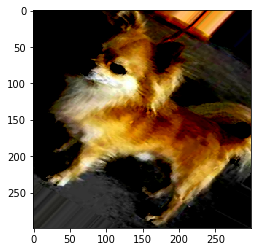

In [33]:
plt.imshow(train_generator[0][0][18]) # show random image obtained from generator

#### Training last layer of xception NN

Below in the same way last layer of Xception architecture is trained

In [12]:
output = xcep.layers[-1].output
for layer in xcep.layers:
    layer.trainable = False
xcept = Sequential()
xcept.add(xcep)

xcept.add(Dense(10, activation='softmax'))

xcept.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
            metrics=['accuracy'])

In [13]:
epochs = 10
batch_size = 32

train_datagen = ImageDataGenerator( 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_xcep,y_train_xcep,
                                        batch_size=batch_size)

validation_generator = test_datagen.flow(X_val_xcep,y_val_xcep, 
                                                        batch_size=batch_size)

history_xcep = History()
early_stopping = EarlyStopping(patience=3,monitor="val_loss")

xcept.fit_generator(train_generator, steps_per_epoch=round(len(X_train_xcep)/32), epochs=epochs, 
                    validation_data=validation_generator,validation_steps=round(len(X_val_xcep)/32),callbacks=[early_stopping, history_xcep])

Epoch 1/10
32/32 [==============================] - 1045s 33s/step - loss: 1.3869 - acc: 0.6740 - val_loss: 0.5991 - val_acc: 0.9673
Epoch 2/10
32/32 [==============================] - 1137s 36s/step - loss: 0.5440 - acc: 0.9010 - val_loss: 0.2901 - val_acc: 0.9760
Epoch 3/10
32/32 [==============================] - 1172s 37s/step - loss: 0.3853 - acc: 0.9140 - val_loss: 0.2106 - val_acc: 0.9717
Epoch 4/10
32/32 [==============================] - 1068s 33s/step - loss: 0.3210 - acc: 0.9070 - val_loss: 0.1744 - val_acc: 0.9717
Epoch 5/10
32/32 [==============================] - 1198s 37s/step - loss: 0.3170 - acc: 0.9200 - val_loss: 0.1580 - val_acc: 0.9717
Epoch 6/10
32/32 [==============================] - 1229s 38s/step - loss: 0.2470 - acc: 0.9330 - val_loss: 0.1482 - val_acc: 0.9717
Epoch 7/10
32/32 [==============================] - 1193s 37s/step - loss: 0.2540 - acc: 0.9320 - val_loss: 0.1351 - val_acc: 0.9651
Epoch 8/10
32/32 [==============================] - 1371s 43s/step - 

In [14]:
xcept.save_weights('/home/mobr93/Pulpit/bootcamp_DS/projekt/wytrenowane modele/xcep') # save only weights


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


In [15]:
xcept.save('/home/mobr93/Pulpit/bootcamp_DS/projekt/wytrenowane modele/xcep_model.h5') # save whole model

In [16]:
xcept.evaluate(x=X_test2_xcep,y=y_test2_xcep)

460/460 [==============================] - 336s 729ms/sample - loss: 0.1869 - acc: 0.9413


[0.18691898399721021, 0.9413043]

accuracy=94,1%

#### Training last layer of RestNet NN without data augmentation

Below last layer of Resnet will be trained with and without data augmentation

In [13]:
output = restnet.layers[-1].output
for layer in restnet.layers:
    layer.trainable = False

In [14]:
history_1 = History()
early_stopping = EarlyStopping(patience=3,monitor="val_loss")


In [15]:
model2 = Sequential()
model2.add(restnet)
model2.add(Dense(10, activation='softmax'))

#model2.summary()

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
            metrics=['accuracy'])

In [32]:
model2.fit(X_train_res, y_train_res, validation_data= (X_val_res, y_val_res),epochs=15,batch_size=32,callbacks=[early_stopping, history_1])

Train on 1000 samples, validate on 459 samples
Epoch 1/15
1000/1000 [==============================] - 466s 466ms/sample - loss: 0.0352 - acc: 0.9910 - val_loss: 0.3457 - val_acc: 0.8976
Epoch 2/15
1000/1000 [==============================] - 540s 540ms/sample - loss: 0.0255 - acc: 0.9970 - val_loss: 0.3160 - val_acc: 0.8998
Epoch 3/15
1000/1000 [==============================] - 503s 503ms/sample - loss: 0.0178 - acc: 0.9990 - val_loss: 0.3304 - val_acc: 0.9020
Epoch 4/15
1000/1000 [==============================] - 513s 513ms/sample - loss: 0.0150 - acc: 0.9990 - val_loss: 0.3202 - val_acc: 0.9020
Epoch 5/15
1000/1000 [==============================] - 477s 477ms/sample - loss: 0.0165 - acc: 1.0000 - val_loss: 0.3932 - val_acc: 0.8889


It is visible that without data augmentation model does not generalize well - training accuracy is almost 100% after only 2 epochs and gap between training (100%)/validation (89%)/test accuracy (87% as calculated below) is pretty huge.

In [38]:
model2.evaluate(X_test2_res,y_test2_res)

460/460 [==============================] - 118s 256ms/sample - loss: 0.3900 - acc: 0.8652


[0.3900179202789846, 0.8652174]

In [33]:
model2.save_weights('/home/mobr93/Pulpit/bootcamp_DS/projekt/wytrenowane modele/resnet_model2')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


In [37]:
# load the weights
model2.load_weights('/home/mobr93/Pulpit/bootcamp_DS/projekt/wytrenowane modele/resnet_model2')

#### Training last layer of RestNet NN with data augmentation

In [16]:
# In ResNet preprocessed images are converted from RGB to BGR, then each color channel is zero-centered
# with respect to the ImageNet dataset without scaling
X_train_res[0]

array([[[-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        [-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        [-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        ...,
        [-9.0939003e+01, -6.7778999e+01, -5.8680000e+01],
        [-9.0939003e+01, -6.7778999e+01, -5.8680000e+01],
        [-9.0939003e+01, -6.7778999e+01, -5.8680000e+01]],

       [[-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        [-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        [-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        ...,
        [-9.0939003e+01, -6.7778999e+01, -5.8680000e+01],
        [-9.0939003e+01, -6.7778999e+01, -5.8680000e+01],
        [-9.0939003e+01, -6.7778999e+01, -5.8680000e+01]],

       [[-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        [-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        [-9.8939003e+01, -9.3778999e+01, -9.3680000e+01],
        ...,
        [-9.0939003e+01, -6.7778999e+01, -5.8680000e+01],
        [-9.0939003e+01, -6.7

In [17]:
epochs = 10
batch_size = 32

train_datagen = ImageDataGenerator( 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_res,y_train_res,
                                        batch_size=batch_size)

validation_generator = test_datagen.flow(X_val_res,y_val_res, 
                                                        batch_size=batch_size)

In [18]:
model3 = Sequential()
model3.add(restnet)

model3.add(Dense(10, activation='softmax'))

#model2.summary()

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
            metrics=['accuracy'])

In [19]:
history_2 = History()
early_stopping = EarlyStopping(patience=3,monitor="val_loss")

model3.fit_generator(train_generator, steps_per_epoch=round(len(X_train_res)/32), epochs=epochs, 
                    validation_data=validation_generator,validation_steps=round(len(X_val_res)/32),callbacks=[early_stopping, history_2])

Epoch 1/10
32/32 [==============================] - 525s 16s/step - loss: 1.5711 - acc: 0.4960 - val_loss: 0.6026 - val_acc: 0.8017
Epoch 2/10
32/32 [==============================] - 475s 15s/step - loss: 0.7185 - acc: 0.7840 - val_loss: 0.3546 - val_acc: 0.8845
Epoch 3/10
32/32 [==============================] - 442s 14s/step - loss: 0.5313 - acc: 0.8360 - val_loss: 0.3110 - val_acc: 0.8867
Epoch 4/10
32/32 [==============================] - 488s 15s/step - loss: 0.4480 - acc: 0.8810 - val_loss: 0.3414 - val_acc: 0.8867
Epoch 5/10
32/32 [==============================] - 516s 16s/step - loss: 0.3636 - acc: 0.8940 - val_loss: 0.3312 - val_acc: 0.8954
Epoch 6/10
32/32 [==============================] - 462s 14s/step - loss: 0.3164 - acc: 0.9110 - val_loss: 0.2918 - val_acc: 0.9085
Epoch 7/10
32/32 [==============================] - 454s 14s/step - loss: 0.2604 - acc: 0.9310 - val_loss: 0.3079 - val_acc: 0.9063
Epoch 8/10
32/32 [==============================] - 455s 14s/step - loss: 0.

In case data augmentation is used performance of the model is better (89% accuracy on test set vs 87% without augmentation) and also gap between train(93%)/validation(91%)/test set(89%) is better aligned.

In [21]:
model3.evaluate(X_test2_res,y_test2_res)

460/460 [==============================] - 130s 283ms/sample - loss: 0.3286 - acc: 0.8913


[0.3286181953290234, 0.8913044]

In [20]:
model3.save('/home/mobr93/Pulpit/bootcamp_DS/projekt/wytrenowane modele/resnet_model3.h5')

#### Training logistic regression on features from Inception_v3 NN

In [9]:
# loading pretrained model without top layer
IMG_WIDTH=299
IMG_HEIGHT=299
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
inception_v3 = InceptionV3(include_top=False,
                   weights='imagenet',
                   pooling = 'avg', 
                   input_shape=(IMG_HEIGHT,IMG_WIDTH,3),backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
inception_v3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [13]:
# extracting features from Inception model
train_reg = inception_v3.predict(X_train_inc, batch_size=32, verbose=1)
test2_reg = inception_v3.predict(X_test2_inc, batch_size=32, verbose=1)
print('InceptionV3 train features shape: {} size: {:,}'.format(train_reg.shape, train_reg.size))

460/460 [==============================] - 154s 334ms/sample
InceptionV3 train features shape: (1000, 2048) size: 2,048,000


In [15]:
# saving datasets with features
with open("train_inc_pred.pickle", "wb") as data:
    pickle.dump(train_reg, data)
with open("test2_inc_pred.pickle", "wb") as data:
    pickle.dump(test2_reg, data)

In [11]:
# loading datasets with features
with open("train_inc_pred.pickle", "rb") as data:
    train_reg = pickle.load(data)
with open("test2_inc_pred.pickle", "rb") as data:
    test2_reg = pickle.load(data)

In [14]:
train_reg[0]

array([0.07185128, 0.31060335, 0.1645513 , ..., 0.08780035, 0.38340107,
       0.14073902], dtype=float32)

In [13]:
train_reg[0].shape # for each image we have 2048 features

(2048,)

In [14]:
# training logistic regression on features from Inception model
log_inc = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
log_inc.fit(train_reg, y_train_inc)
test2_inc_preds = log_inc.predict(test2_reg)
train_inc_preds=log_inc.predict(train_reg)
print('Test2 Inception Accuracy {}'.format(accuracy_score(y_test2_inc, test2_inc_preds)))

Test2 Inception Accuracy 0.967391304347826


/home/mobr93/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### Training logistic regression on features from Xception NN

In [3]:
# loading of pretrained Xception model without top layer
IMG_WIDTH=299
IMG_HEIGHT=299
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
xcep = Xception(include_top=False,
                   weights='imagenet',
                   pooling = 'avg',
                   input_shape=(IMG_HEIGHT,IMG_WIDTH,3),backend=keras.backend,
                  layers=keras.layers,
                  models=keras.models,
                  utils=keras.utils)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# extracting features from Xception model
train_reg_xc = xcep.predict(X_train_xcep, batch_size=32, verbose=1)
test2_reg_xc = xcep.predict(X_test2_xcep, batch_size=32, verbose=1)
print('Xcep train features shape: {}'.format(train_reg_xc.shape))

460/460 [==============================] - 355s 772ms/sample
Xcep train features shape: (1000, 2048)


In [5]:
# saving datasets with features
with open("train_xc_pred.pickle", "wb") as data:
    pickle.dump(train_reg_xc, data)
with open("test2_xc_pred.pickle", "wb") as data:
    pickle.dump(test2_reg_xc, data)

In [ ]:
# loading datasets with features
with open("train_xc_pred.pickle", "rb") as data:
    train_reg_xc = pickle.load(data)
with open("test2_xc_pred.pickle", "rb") as data:
    test2_reg_xc = pickle.load(data)

In [6]:
# training logistic regression on features from Xception model
log_xcep = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
log_xcep.fit(train_reg_xc, y_train_xcep)
test2_xc_preds = log_xcep.predict(test2_reg_xc)
train_xc_preds=log_xcep.predict(train_reg_xc)
print('Test2 Xception Accuracy {}'.format(accuracy_score(y_test2_xcep, test2_xc_preds)))

Test2 Xception Accuracy 0.9608695652173913


/home/mobr93/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Summary of results:
#### Inception_v3
* baseline (pretrained) 91%
* training last layer 96%
* training logistic regression on features 97%

#### Xception

* baseline (pretrained) 91%
* training last layer 94%
* training logistic regression on features 96%

#### Resnet

* baseline (pretrained) 78%
* training last layer without data augmentation 86,5%
* training last layer with data augmentation 89%

## Part 3: Training algorithms on given datases (not using pretrained models)
#### Following algorithms will be checked:
* Own structure of NN
* Random forest
* Logistic regression

Images were reshaped to 100x100 format as this allow to have proper balance between image quality and computational capacity (arbitrary chosen looking at images quality and speed of learning)

In [15]:
# load images in 100x100 format
X_train_100_org,y_train_100=load_train(100,100)
X_test_100_org,y_test_100=load_test(100,100)

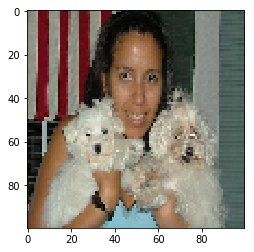

In [12]:
# show random image quality
img=X_train_100_org[200]
plt.imshow(img/255)

In [16]:
# division of original Stanford test set into validation/test set as for previous models
X_val_100_org,X_test2_100_org,y_val_100,y_test2_100=train_test_split(X_test_100_org,y_test_100,test_size=0.5,random_state=42)

In [47]:
X_train_100_org[0].shape

(100, 100, 3)

Neural network

In [33]:
epochs = 15
batch_size = 32

# in this case scaling is needeed as images were not preprocessed earlier

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train_100_org,y_train_100,
                                        batch_size=batch_size)

validation_generator = test_datagen.flow(X_val_100_org,y_val_100, 
                                                        batch_size=batch_size)

Below different architectures are trained and the best one basing on validation accuracy will be chosen and trained further with more epochs

In [35]:
early_stopping = EarlyStopping(patience=3,monitor="val_loss")

dense_layers = [1,2]
layer_sizes = [32,64]
conv_layers = [2,3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X_train_100_org.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(10))
            model.add(Activation('softmax'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='sparse_categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy']
                          )
            
            model.fit_generator(train_generator, steps_per_epoch=round(len(X_train_100_org)/32), epochs=epochs, 
                    validation_data=validation_generator,validation_steps=round(len(X_val_100_org)/32),callbacks=[early_stopping, tensorboard])

2-conv-32-nodes-1-dense-1591729728
Epoch 1/15
32/32 [==============================] - 15s 471ms/step - loss: 2.3258 - acc: 0.1240 - val_loss: 2.2688 - val_acc: 0.2244
Epoch 2/15
32/32 [==============================] - 15s 468ms/step - loss: 2.2581 - acc: 0.1600 - val_loss: 2.2298 - val_acc: 0.1786
Epoch 3/15
32/32 [==============================] - 16s 490ms/step - loss: 2.2057 - acc: 0.1800 - val_loss: 2.2161 - val_acc: 0.1373
Epoch 4/15
32/32 [==============================] - 15s 466ms/step - loss: 2.1564 - acc: 0.1890 - val_loss: 2.0871 - val_acc: 0.2331
Epoch 5/15
32/32 [==============================] - 16s 499ms/step - loss: 2.0904 - acc: 0.2450 - val_loss: 1.9906 - val_acc: 0.2810
Epoch 6/15
32/32 [==============================] - 16s 500ms/step - loss: 2.0506 - acc: 0.2710 - val_loss: 2.0159 - val_acc: 0.2723
Epoch 7/15
32/32 [==============================] - 15s 483ms/step - loss: 1.9957 - acc: 0.3110 - val_loss: 1.9630 - val_acc: 0.3094
Epoch 8/15
32/32 [================

Epoch 6/15
32/32 [==============================] - 16s 501ms/step - loss: 2.2100 - acc: 0.1860 - val_loss: 2.2168 - val_acc: 0.1590
Epoch 7/15
32/32 [==============================] - 16s 507ms/step - loss: 2.1477 - acc: 0.2280 - val_loss: 2.2301 - val_acc: 0.1830
Epoch 8/15
32/32 [==============================] - 16s 511ms/step - loss: 2.1193 - acc: 0.2360 - val_loss: 2.0961 - val_acc: 0.2614
Epoch 9/15
32/32 [==============================] - 16s 508ms/step - loss: 2.0492 - acc: 0.2720 - val_loss: 2.0207 - val_acc: 0.2876
Epoch 10/15
32/32 [==============================] - 16s 504ms/step - loss: 2.0270 - acc: 0.2630 - val_loss: 2.0305 - val_acc: 0.2832
Epoch 11/15
32/32 [==============================] - 16s 499ms/step - loss: 2.0330 - acc: 0.2870 - val_loss: 2.0448 - val_acc: 0.2680
Epoch 12/15
32/32 [==============================] - 16s 507ms/step - loss: 1.9958 - acc: 0.3020 - val_loss: 2.0169 - val_acc: 0.2658
Epoch 13/15
32/32 [==============================] - 16s 499ms/ste

After analyzing detailed results from log above and tensorboard, structure with 3 Convolutions layers, 2 Dense layers and 64 as layer_size was chosen as best one (basing on validation accuracy and increasing accuracy trend which can suggest further training with more epochs may improve results). To open tensorboard it is needed to type 'tensorboard --logdir=logs/.' in console.
This neural network will be trained further for more epochs as it reached maximum validation accuracy after maximum epochs allowed (15) therefore it may still be improved after further training.

In [48]:
# loading of tensorboard print screen with validation accuracy for all neural network architectures trained
img = 'tensorboard_1.png'
Image(url=img)

In [36]:
# specification of chosen structure for further training

layer_size=64
final_nn=Sequential()
final_nn.add(Conv2D(layer_size, (3, 3), input_shape=X_train_100_org.shape[1:]))
final_nn.add(Activation('relu'))
final_nn.add(MaxPooling2D(pool_size=(2, 2)))

for l in range(2):
    final_nn.add(Conv2D(layer_size, (3, 3)))
    final_nn.add(Activation('relu'))
    final_nn.add(MaxPooling2D(pool_size=(2, 2)))

final_nn.add(Flatten())

for _ in range(2):
    final_nn.add(Dense(layer_size))
    final_nn.add(Activation('relu'))

final_nn.add(Dense(10))
final_nn.add(Activation('softmax'))

final_nn.compile(loss='sparse_categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy']
                          )
final_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
activation_69 (Activation)   (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
activation_70 (Activation)   (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 21, 21, 64)        36928     
__________

In [37]:
epochs = 100 # this NN will be trained for more epochs 
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train_100_org,y_train_100,
                                        batch_size=batch_size)

validation_generator = test_datagen.flow(X_val_100_org,y_val_100, 
                                                        batch_size=batch_size)

tensorboard = TensorBoard(log_dir="logs_finalNN/")

final_nn.fit_generator(train_generator, steps_per_epoch=round(len(X_train_100_org)/32), epochs=epochs, 
                    validation_data=validation_generator,validation_steps=round(len(X_val_100_org)/32),callbacks=[early_stopping, tensorboard])

Epoch 1/100
32/32 [==============================] - 41s 1s/step - loss: 2.3065 - acc: 0.0930 - val_loss: 2.3104 - val_acc: 0.1024
Epoch 2/100
32/32 [==============================] - 41s 1s/step - loss: 2.3035 - acc: 0.1190 - val_loss: 2.2940 - val_acc: 0.1068
Epoch 3/100
32/32 [==============================] - 40s 1s/step - loss: 2.2921 - acc: 0.0980 - val_loss: 2.2684 - val_acc: 0.1460
Epoch 4/100
32/32 [==============================] - 40s 1s/step - loss: 2.2599 - acc: 0.1580 - val_loss: 2.2133 - val_acc: 0.1198
Epoch 5/100
32/32 [==============================] - 41s 1s/step - loss: 2.1491 - acc: 0.2160 - val_loss: 2.1113 - val_acc: 0.2288
Epoch 6/100
32/32 [==============================] - 41s 1s/step - loss: 2.0588 - acc: 0.2550 - val_loss: 2.1054 - val_acc: 0.2266
Epoch 7/100
32/32 [==============================] - 39s 1s/step - loss: 2.0434 - acc: 0.2560 - val_loss: 1.9858 - val_acc: 0.2832
Epoch 8/100
32/32 [==============================] - 40s 1s/step - loss: 1.9460 - a

In [38]:
final_nn.save_weights('/home/mobr93/Pulpit/bootcamp_DS/projekt/wytrenowane modele/my_NN')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


In [50]:
final_nn.evaluate(x=X_test2_100_org/255.,y=y_test2_100)[1]

460/460 [==============================] - 5s 11ms/sample - loss: 1.8892 - acc: 0.3652


0.3652174

accuracy of own neural network - 37%

#### Random Forest 

In [42]:
# reshaping dataset for 1D format to train random forest/logistic regression
X_train_1d=X_train_100_org.reshape(-1,100*100*3)
X_val_1d=X_val_100_org.reshape(-1,100*100*3)
X_test2_1d=X_test2_100_org.reshape(-1,100*100*3)

In [43]:
X_train_1d.shape,X_val_1d.shape

((1000, 30000), (459, 30000))

In [44]:
# basic random forest with some parameters values set to mitigate overfitting
# (max_features=0.8, min_samples_leaf=5)
bag=BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=5),
                      max_features=0.8,max_samples=0.8,bootstrap=False,n_estimators=50)
bag.fit(X_train_1d,y_train_100)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=5,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [45]:
accuracy_score(bag.predict(X_test2_1d),y_test2_100)

0.25869565217391305

#### logistic regression basic

In [46]:
log_reg=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
log_reg.fit(X_train_1d,y_train_100)

/home/mobr93/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
accuracy_score(log_reg.predict(X_test2_1d),y_test2_100)

0.2108695652173913

### Summary of results:
- Neural network: 37%
- Random forest: 26%
- Logistic regression: 21%

For Random Forest/Logistic regression no hyperparameter optimization (bayes optimization/grid search) was done as this was too computationally expensive and te aim was just to check how this baseline models will perform without much investigations.

## Part 4: Stacking of best models

For stacking features from Inception/Xception neural networks were chosen as this models perform best.

In [13]:
# loading datasets with inception/xception features 
with open("train_inc_pred.pickle", "rb") as xcep:
    train_inc_pred=pickle.load(xcep)
with open("test2_inc_pred.pickle", "rb") as xcep:
    test2_inc_pred=pickle.load(xcep)
    
with open("train_xc_pred.pickle", "rb") as xcep:
    train_xc_pred=pickle.load(xcep)
with open("test2_xc_pred.pickle", "rb") as xcep:
    test2_xc_pred=pickle.load(xcep)

In [16]:
log_reg = LogisticRegression()

In [17]:
# concatenating features from both NN
train_meta = np.concatenate((train_xc_pred,train_inc_pred),axis=1)

In [18]:
train_meta.shape

(1000, 4096)

In [19]:
train_meta[0]

array([0.        , 0.23194028, 0.23765135, ..., 0.08780035, 0.38340107,
       0.14073902], dtype=float32)

In [20]:
# training logistic regression on Inception+Xception features
log_reg.fit(train_meta, y_train_xcep)

/home/mobr93/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mobr93/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
log_reg.coef_

array([[-0.02740913, -0.01513764,  0.01511812, ..., -0.05064071,
        -0.049933  ,  0.03385685],
       [-0.0376079 , -0.03242176, -0.00490185, ..., -0.04050829,
         0.06634608, -0.01540886],
       [-0.0058759 , -0.0224515 , -0.01622769, ...,  0.08826459,
         0.01550622, -0.02359589],
       ...,
       [ 0.01719734,  0.05092342,  0.02895438, ...,  0.0359619 ,
         0.05116135, -0.02328498],
       [ 0.02193833, -0.01031576, -0.01160264, ..., -0.0189714 ,
         0.05114292,  0.0026511 ],
       [-0.00045731, -0.01913586,  0.00277831, ..., -0.0319399 ,
        -0.01025881, -0.02943206]])

In [24]:
# concatenating features for test set to evaluate model
test2_meta = np.concatenate((test2_xc_pred,test2_inc_pred),axis=1)

In [25]:
accuracy_score(log_reg.predict(test2_meta),y_test2_xcep)

0.9717391304347827

### Summary of results
* xception + inception=97.2% (xception standalone 96%, inception standalone 96.8%). Stacking improved accuracy only a little (around 0.4%).

### Part 5: Results exploration
For detailed result analysis best performing model on standalone basis (logistic regression trained on inceptions' features) was chosen (stacking of models was not considered here as it improves score only a little and meanwhile is much more complex which is not favourable)

In [17]:
# loading Inception features
with open("train_inc_pred.pickle", "rb") as xcep:
    train_inc_pred = pickle.load(xcep)
with open("test2_inc_pred.pickle", "rb") as xcep:
    test2_inc_pred = pickle.load(xcep)

In [18]:
# training logistic regression on this features one more time as it was done in Part 2.
log_inc = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
log_inc.fit(train_inc_pred, y_train_inc)
test2_inc_log_p = log_inc.predict(test2_inc_pred)
train_inc_log_p=log_inc.predict(train_inc_pred)
print('Test2 Inception Accuracy {}'.format(accuracy_score(y_test2_inc, test2_inc_log_p)))

Test2 Inception Accuracy 0.967391304347826


/home/mobr93/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Below confusion matrix is calculated which can give us insight into model errors

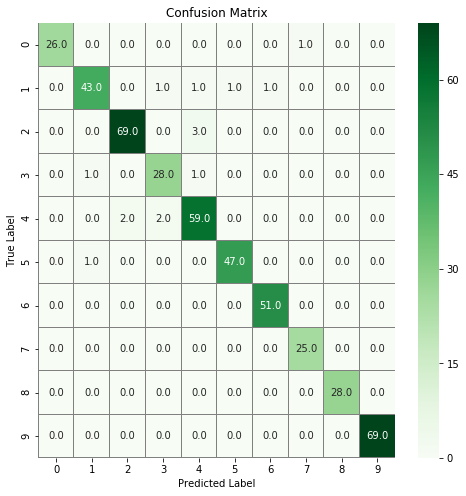

In [23]:
# confusion matrix
Y_pred_classes = test2_inc_log_p
Y_true = y_test2_inc
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

It can be concluded from confusion matrix that we always predict correctly (accuracy=100%!) following labels: 0,8,9 and we make only one mistake for labels 5,6,7. The most mistakes (4) are made for label 4. Generally all model mistakes do not come from one label but are rather reasonably distributed between classess.

As there is only 15 mistakes overall we can look in next step at all this images one by one to get additional insights

In [92]:
miss_class=np.where(Y_pred!=Y_true)[0].tolist() # indexes of model misclassifications

In [93]:
miss_class

[1, 9, 31, 120, 153, 173, 196, 205, 235, 239, 281, 288, 324, 373, 384]

In [57]:
y_test2_inc # true labels

array([1, 1, 3, 3, 8, 5, 9, 5, 7, 5, 7, 2, 9, 3, 1, 6, 0, 4, 5, 2, 4, 4,
       4, 5, 0, 4, 9, 2, 2, 1, 4, 2, 6, 5, 8, 2, 4, 1, 6, 6, 5, 3, 2, 1,
       1, 6, 0, 4, 6, 3, 4, 4, 8, 1, 8, 8, 7, 6, 6, 9, 9, 3, 7, 6, 9, 6,
       5, 2, 9, 6, 0, 2, 1, 2, 8, 9, 3, 7, 2, 9, 5, 7, 8, 8, 9, 2, 6, 1,
       2, 2, 8, 5, 1, 3, 3, 1, 9, 2, 9, 9, 6, 2, 2, 2, 9, 9, 1, 2, 3, 9,
       7, 9, 9, 4, 6, 8, 8, 2, 4, 7, 3, 4, 9, 5, 9, 6, 4, 6, 9, 9, 4, 1,
       7, 9, 4, 5, 6, 5, 4, 1, 2, 8, 7, 6, 8, 7, 2, 0, 7, 3, 2, 5, 9, 4,
       6, 0, 0, 7, 6, 5, 2, 1, 1, 9, 2, 1, 3, 3, 4, 4, 9, 3, 4, 0, 1, 2,
       5, 3, 4, 1, 2, 2, 6, 9, 5, 9, 0, 1, 0, 9, 3, 7, 2, 5, 1, 9, 3, 0,
       1, 5, 3, 7, 9, 2, 4, 1, 4, 9, 6, 9, 9, 2, 2, 8, 7, 7, 3, 6, 4, 9,
       4, 2, 8, 8, 1, 4, 3, 7, 2, 5, 8, 0, 4, 2, 6, 4, 1, 2, 4, 4, 3, 4,
       5, 8, 3, 8, 0, 9, 5, 9, 6, 2, 5, 9, 6, 9, 4, 5, 4, 9, 9, 9, 3, 7,
       2, 1, 2, 9, 7, 5, 4, 4, 1, 6, 6, 4, 6, 7, 5, 6, 5, 4, 5, 2, 8, 3,
       4, 9, 1, 9, 2, 6, 9, 1, 3, 1, 5, 5, 1, 2, 0,

In [56]:
test2_inc_log_p # predicted labels

array([1, 4, 3, 3, 8, 5, 9, 5, 7, 1, 7, 2, 9, 3, 1, 6, 0, 4, 5, 2, 4, 4,
       4, 5, 0, 4, 9, 2, 2, 1, 4, 4, 6, 5, 8, 2, 4, 1, 6, 6, 5, 3, 2, 1,
       1, 6, 0, 4, 6, 3, 4, 4, 8, 1, 8, 8, 7, 6, 6, 9, 9, 3, 7, 6, 9, 6,
       5, 2, 9, 6, 0, 2, 1, 2, 8, 9, 3, 7, 2, 9, 5, 7, 8, 8, 9, 2, 6, 1,
       2, 2, 8, 5, 1, 3, 3, 1, 9, 2, 9, 9, 6, 2, 2, 2, 9, 9, 1, 2, 3, 9,
       7, 9, 9, 4, 6, 8, 8, 2, 4, 7, 4, 4, 9, 5, 9, 6, 4, 6, 9, 9, 4, 1,
       7, 9, 4, 5, 6, 5, 4, 1, 2, 8, 7, 6, 8, 7, 2, 0, 7, 3, 2, 5, 9, 3,
       6, 0, 0, 7, 6, 5, 2, 1, 1, 9, 2, 1, 3, 3, 4, 4, 9, 3, 4, 7, 1, 2,
       5, 3, 4, 1, 2, 2, 6, 9, 5, 9, 0, 1, 0, 9, 3, 7, 2, 5, 1, 9, 1, 0,
       1, 5, 3, 7, 9, 2, 4, 5, 4, 9, 6, 9, 9, 2, 2, 8, 7, 7, 3, 6, 4, 9,
       4, 2, 8, 8, 1, 4, 3, 7, 2, 5, 8, 0, 4, 2, 6, 3, 1, 2, 4, 2, 3, 4,
       5, 8, 3, 8, 0, 9, 5, 9, 6, 2, 5, 9, 6, 9, 4, 5, 4, 9, 9, 9, 3, 7,
       2, 1, 2, 9, 7, 5, 4, 4, 1, 6, 6, 4, 6, 7, 5, 6, 5, 2, 5, 2, 8, 3,
       4, 9, 6, 9, 2, 6, 9, 1, 3, 1, 5, 5, 1, 2, 0,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

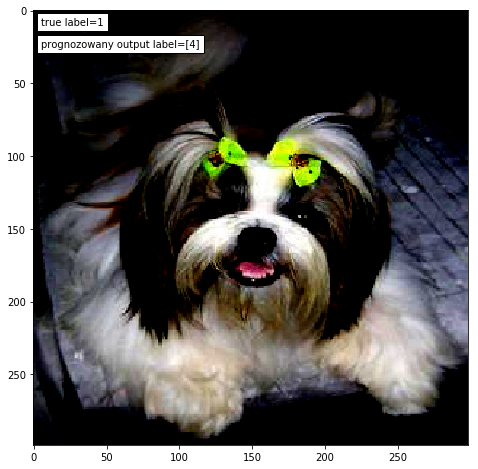

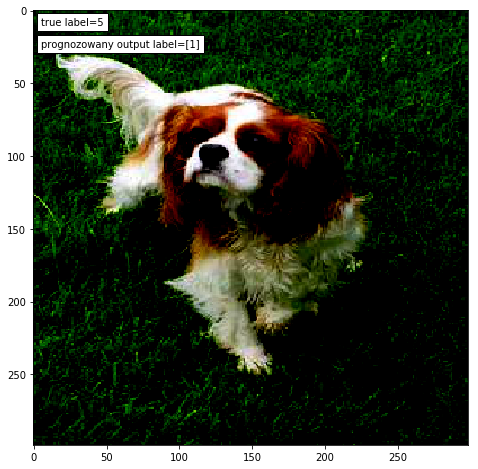

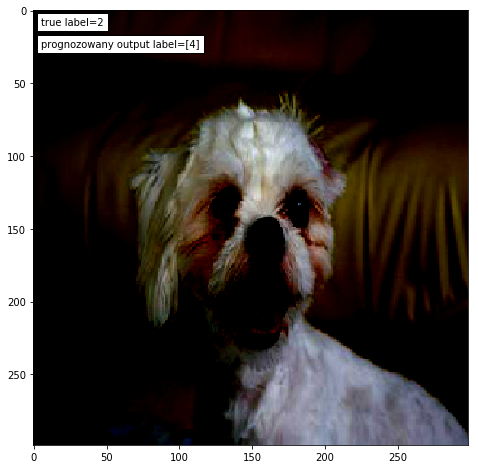

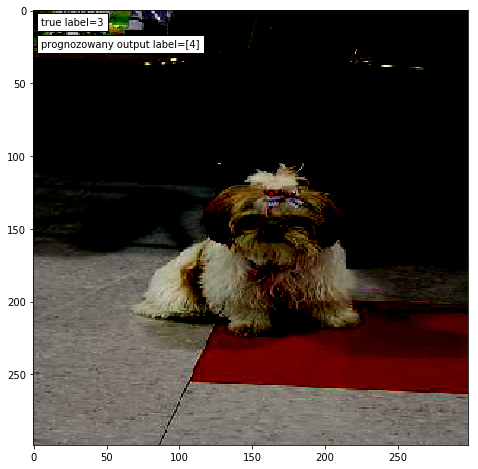

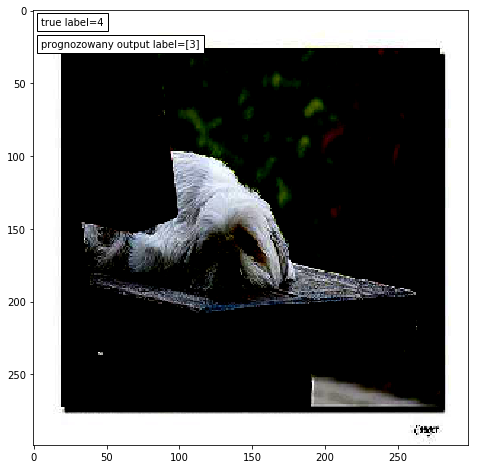

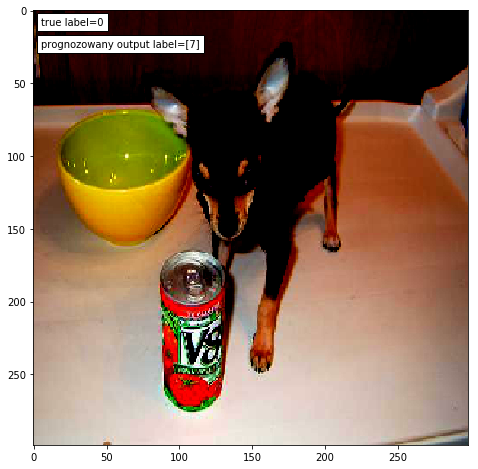

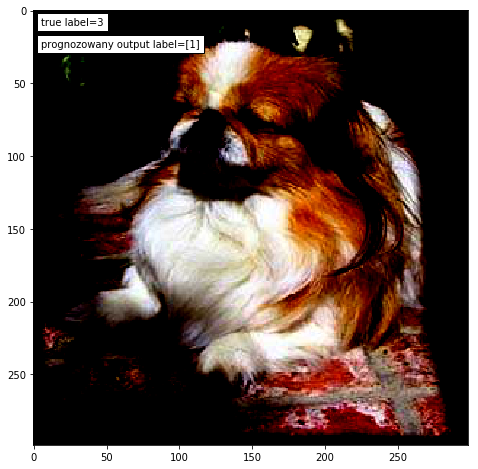

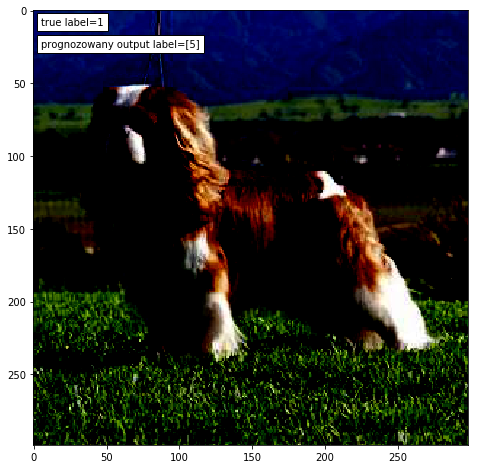

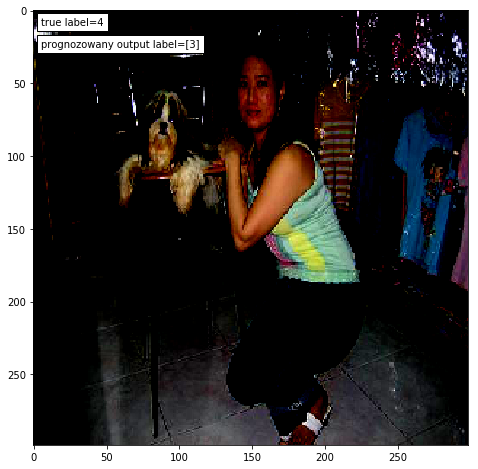

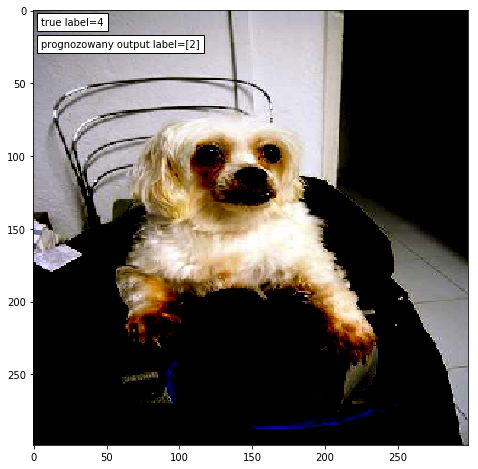

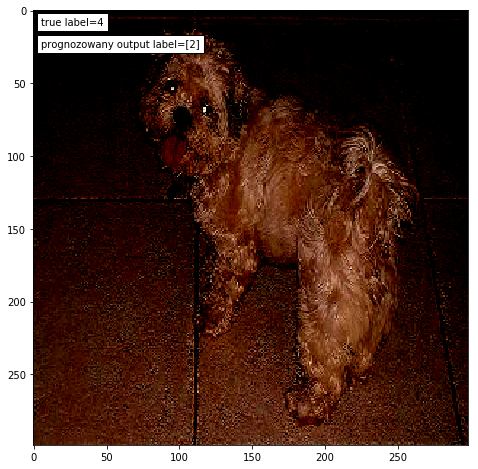

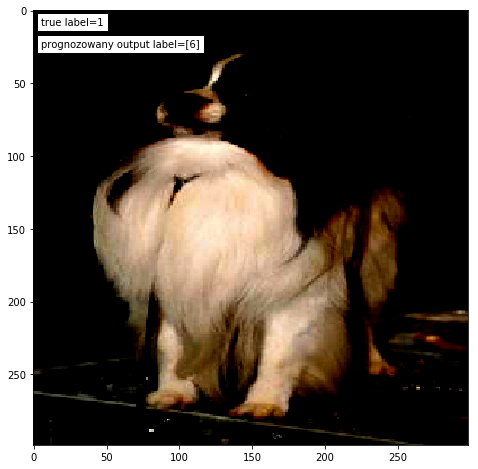

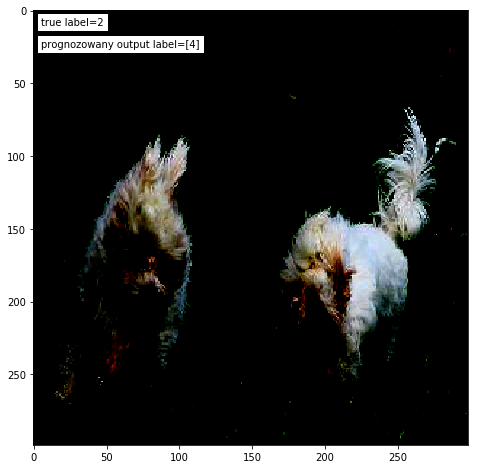

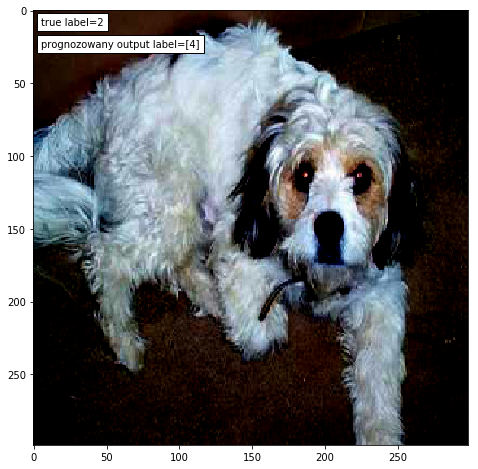

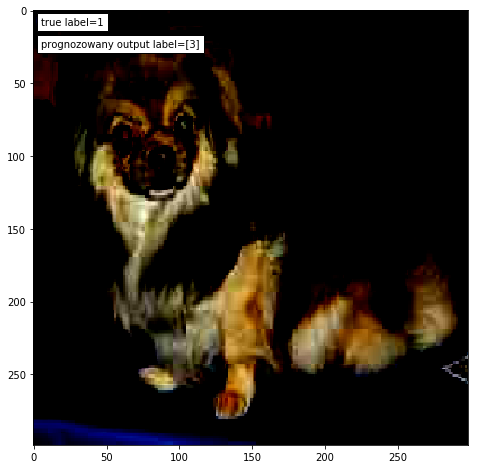

In [102]:
# showing all 15 misclassified images with true label and predicted ones
sprawdz_1(X_test2_inc,test2_inc_pred,y_test2_inc,log_inc,miss_class)

All of this mistakes are quite 'reasonable' - even if model does not predict correctly it predicts breed which is quite similar to the true one. Furthermore most of model errors are connected with labels 2 and 4 (Maltese dog and Shih-Tzu) and this breeds are generally the most similar to each other.

In [103]:
# recap of labels-breed mapping
rasy_train

{'Chihuahua': 0,
 'Japanese_spaniel': 1,
 'Maltese_dog': 2,
 'Pekinese': 3,
 'Shih-Tzu': 4,
 'Blenheim_spaniel': 5,
 'papillon': 6,
 'toy_terrier': 7,
 'Rhodesian_ridgeback': 8,
 'Afghan_hound': 9}

## Summary of results

Let's recap all results from 5 modelling parts

### PART 1 - pretrained models

* resnet 80%
* vgg16 76%
* **inception_v3 91%**
* densenet 85%
* mobilenet_v2 86%
* **xception 91%**

### PART 2 - transfer learning
#### Inception_v3
* baseline (pretrained) 91%
* training last layer 96%
* training logistic regression on features 97%

#### Xception

* baseline (pretrained) 91%
* training last layer 94%
* training logistic regression on features 96%

#### Resnet

* baseline (pretrained) 78%
* training last layer without data augmentation 86,5%
* training last layer with data augmentation 89%

### PART 3 - own trained models
- Neural network: 37%
- Random forest: 26%
- Logistic regression: 21%

### PART 4 Stacking
* xception + inception=97.2% (xception standalone 96%, inception standalone 96.8%). Stacking improved accuracy only a little (around 0.4%).

Let's put all results into one table

In [12]:
# due to computational complexity it is more efficient to rewrite accuracy scores rathen than
# recalculating them in formulas
accuracy_score=[]
accuracy_score.extend([0.76,0.80,0.85,0.86,0.91,0.91]) # basic models
accuracy_score.extend([0.87,0.89,0.96,0.97,0.94,0.96]) # transfer learning
accuracy_score.extend([0.21,0.26,0.37]) # own trained models
accuracy_score.extend([0.972]) # stacking

In [13]:
models=[]
models.extend(['vgg16 base','ResNet base','DenseNet base','MobileNet_v2 base','Inception_v3 base','Xception base'])
models.extend(['Restnet trained without data augmentation','Restnet trained with data augmentation',
            'Inception_v3 trained last layer',
              'Inception_v3 with log_reg','Xception trained last layer','Xception with log_reg'])
models.extend(['Logistic regression base','Random Forest base','own NN'])
models.extend(['stacked Inception+Xception'])

In [14]:
parts=np.repeat('Part 1',6).tolist()+np.repeat('Part 2',6).tolist()+np.repeat('Part 3',3).tolist()+['Part 4']

In [15]:
len(accuracy_score),len(models),len(parts)

(16, 16, 16)

In [16]:
d = {
    'project part': parts,
     'model': models,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df

,project part,model,accuracy_score
0,Part 1,vgg16 base,0.760
1,Part 1,ResNet base,0.800
2,Part 1,DenseNet base,0.850
3,Part 1,MobileNet_v2 base,0.860
4,Part 1,Inception_v3 base,0.910
5,Part 1,Xception base,0.910
6,Part 2,Restnet trained without data augmentation,0.870
7,Part 2,Restnet trained with data augmentation,0.890
8,Part 2,Inception_v3 trained last layer,0.960
9,Part 2,Inception_v3 with log_reg,0.970


### Project summary
At the end let's note some general thoughts.
1. Best models have very high accuracy (97%) which can be considered as a really good result.
2. It is clearly visible that in image recognition tasks having limited data/resources transfer learning outperforms other solutions quite significantly.
3. There is quite big difference in accuracy between different deep neural networks - Inception and Xception outperform others.
4. Training logistic regression on Inception/Xception features gave better results than training last layer of neural network - it may be related to limited data which was given (logistic regression requires less data for training than neural network).